# SST Image for 2025-02-04T03:12:20Z

In [1]:
from importlib import reload

import numpy as np
from numpy import ma
import xarray
import healpy

from copy import deepcopy

from matplotlib import pyplot as plt
import cartopy.crs as ccrs

from remote_sensing.download import podaac
from remote_sensing.healpix import rs_healpix
from remote_sensing.healpix import plotting as hp_plotting
from remote_sensing.healpix import utils as hp_utils
from remote_sensing.healpix import combine as hp_combine
from remote_sensing import io as rs_io
from remote_sensing import units
from remote_sensing import kml as rs_kml

In [2]:
%matplotlib ipympl

In [3]:
xlim = (127.,134)
ylim = (18.,23)

# Save dict (to avoid repeating some steps if you come back)

In [5]:
sdict = {}
#sdict = rs_io.loadjson('SST_2025-02-04T03.json')

# Download the past day of files in the region

## Grab em

## AMSR2

In [6]:
amsr2_files, _ = podaac.grab_file_list('AMSR2-REMSS-L2P_RT-v8.2', dt_past=dict(days=2),
                                             bbox='127,18,134,23')
amsr2_files

['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/AMSR2-REMSS-L2P_RT-v8.2/20250203160512-REMSS-L2P_GHRSST-SSTsubskin-AMSR2-L2B_rt_r67644-v02.0-fv01.0.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/AMSR2-REMSS-L2P_RT-v8.2/20250203043301-REMSS-L2P_GHRSST-SSTsubskin-AMSR2-L2B_rt_r67637-v02.0-fv01.0.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/AMSR2-REMSS-L2P_RT-v8.2/20250202034948-REMSS-L2P_GHRSST-SSTsubskin-AMSR2-L2B_rt_r67622-v02.0-fv01.0.nc']

## H09

In [7]:
h09_files, _ = podaac.grab_file_list('H09-AHI-L3C-ACSPO-v2.90', dt_past=dict(days=1),
                                             bbox='127,18,134,23')
h09_files[0:2]

['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20250204000000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/H09-AHI-L3C-ACSPO-v2.90/20250203230000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc']

## Download em

In [8]:
reload(podaac)
local_amsr2 = podaac.download_files(amsr2_files, verbose=False)

Using default download directory: /home/xavier/Projects/Oceanography/data/Remote_Sensing/PODAAC
Downloaded 0 files, failed on 0 files, skipped 3 existing files.


In [9]:
local_h09 = podaac.download_files(h09_files, verbose=False)

Using default download directory: /home/xavier/Projects/Oceanography/data/Remote_Sensing/PODAAC
Downloaded 17 files, failed on 0 files, skipped 4 existing files.


In [10]:
sdict['local_amsr2'] = local_amsr2
sdict['local_h09'] = local_h09
# 
jdict = rs_io.jsonify(sdict)
rs_io.savejson('SST_2025-02-04T03.json', jdict, overwrite=True)

# Generate RS_Healpix objects

## AMSR2

In [11]:
reload(rs_healpix)
amsr2_hpxs = []
for data_file in sdict['local_amsr2'][0:1]:
    # Objectify
    rs_hpx = rs_healpix.RS_Healpix.from_dataset_file(
        data_file, 'sea_surface_temperature',
        time_isel=0, resol_km=11., 
        lat_slice=(18,23.),  lon_slice=(127., 134.))
    # 
    print(f"Generated RS_Healpix from {data_file}")
    # Add
    amsr2_hpxs.append(rs_hpx)

Generated RS_Healpix from /home/xavier/Projects/Oceanography/data/Remote_Sensing/PODAAC/AMSR2-REMSS-L2P_RT-v8.2/20250203160512-REMSS-L2P_GHRSST-SSTsubskin-AMSR2-L2B_rt_r67644-v02.0-fv01.0.nc


In [12]:
amsr2_hpxs[0]

<RS_Healpix: nside=512, resol=0.11451621372724687deg
 file=20250203160512-REMSS-L2P_GHRSST-SSTsubskin-AMSR2-L2B_rt_r67644-v02.0-fv01.0.nc, var="sea_surface_temperature">

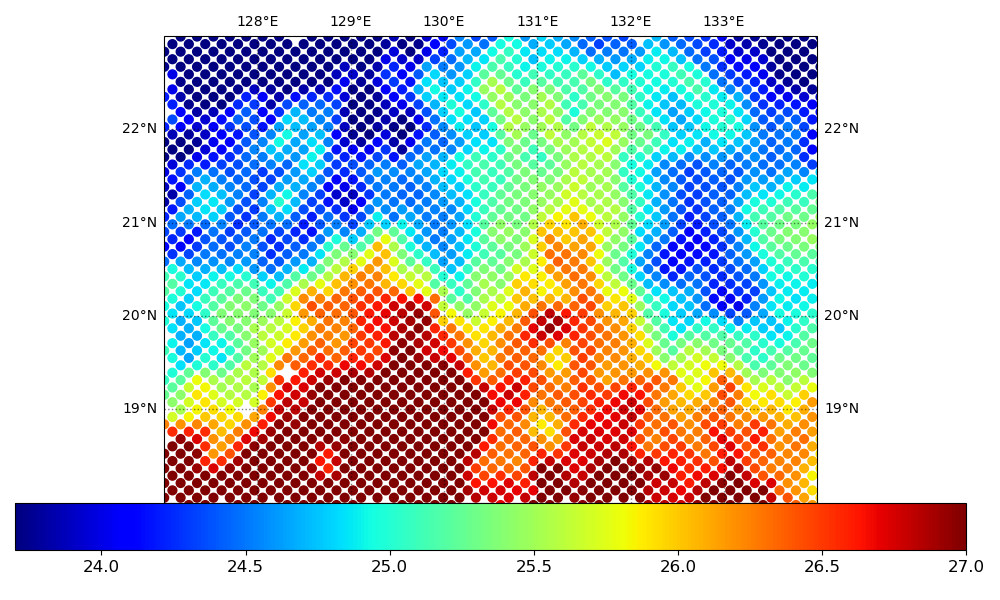

In [13]:
amsr2_hpxs[0].plot(figsize=(10.,6), cmap='jet', xlim=xlim, ylim=ylim,
              projection='platecarree', ssize=40., vmin=23.7, vmax=27.)

## Himawari

In [18]:
reload(rs_healpix)
h09_hpxs = []
# The last 10 hours have been very cloudy
# Using the previous 10
for data_file in sdict['local_h09'][10:20]:
    # Objectify
    rs_hpx = rs_healpix.RS_Healpix.from_dataset_file(
        data_file, 'sea_surface_temperature',
        lat_slice=slice(23,18),  lon_slice=slice(127., 134.), time_isel=0)
    # 
    print(f"Generated RS_Healpix from {data_file}")
    # Add
    h09_hpxs.append(rs_hpx)
    del(rs_hpx)

Generated RS_Healpix from /home/xavier/Projects/Oceanography/data/Remote_Sensing/PODAAC/H09-AHI-L3C-ACSPO-v2.90/20250203140000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc
Generated RS_Healpix from /home/xavier/Projects/Oceanography/data/Remote_Sensing/PODAAC/H09-AHI-L3C-ACSPO-v2.90/20250203130000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc
Generated RS_Healpix from /home/xavier/Projects/Oceanography/data/Remote_Sensing/PODAAC/H09-AHI-L3C-ACSPO-v2.90/20250203120000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc
Generated RS_Healpix from /home/xavier/Projects/Oceanography/data/Remote_Sensing/PODAAC/H09-AHI-L3C-ACSPO-v2.90/20250203110000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc
Generated RS_Healpix from /home/xavier/Projects/Oceanography/data/Remote_Sensing/PODAAC/H09-AHI-L3C-ACSPO-v2.90/20250203100000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc
Generated RS_Healpix from /home/xavier/Projects/Oc

# Average Himawari

In [19]:
reload(rs_healpix)
h09_stack = rs_healpix.RS_Healpix.from_list(h09_hpxs)
h09_stack

<RS_Healpix: nside=2048, resol=0.028629053431811716deg
 file=Avg[20250203140000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc-20250203050000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc], var="sea_surface_temperature">

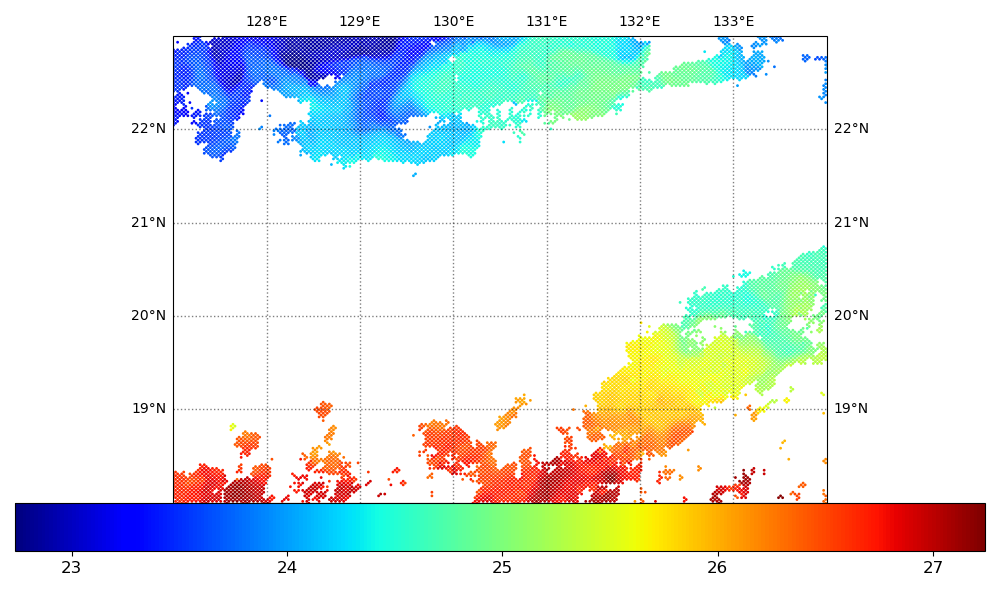

In [20]:
h09_stack.plot(figsize=(10.,6), cmap='jet', xlim=xlim, ylim=ylim,
              projection='platecarree')

# Fill in the gaps

In [22]:
h09_stack.fill_in(amsr2_hpxs[0], (xlim[0], xlim[1], ylim[0], ylim[1]))

Filled in 469852046065 pixels


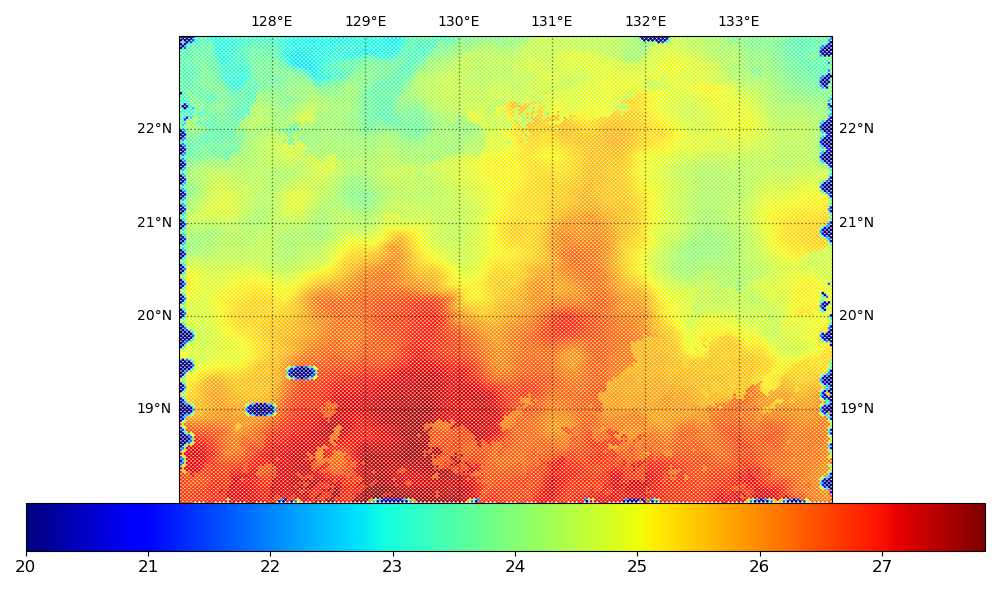

In [23]:
h09_stack.plot(figsize=(10.,6), cmap='jet', xlim=xlim, ylim=ylim,
              projection='platecarree', vmin=20.)